In [14]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import stats
import seaborn

import sensitivity_analysis

# A trivial model

$$R_0(\beta, \gamma, \mu) = \frac{\beta}{\gamma + \mu},$$
where
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4), \\
\gamma &\sim \Gamma(0.01, 4), \\
\mu &\sim \Gamma(0.00001, 4),
\end{aligned}$$
where $\Gamma(a, k)$ is the standard gamma random variable with mean $a$ and shape $k$.

In [2]:
def model(𝛽, 𝛾, 𝜇):
    '''Compute R_0 from the transmission rate, recovery rate, and death rate.'''
    R_0 = 𝛽 / (𝛾 + 𝜇)
    try:
        return R_0.rename('$R_0$')
    except AttributeError:
        return R_0


# Let the transmission rate be a Gamma random variable.
beta_mean = 0.03
beta_shape = 4
beta_scale = beta_mean / beta_shape
beta = stats.gamma(beta_shape, scale=beta_scale)

# Let the recovery rate be a Gamma random variable.
gamma_mean = 0.01
gamma_shape = 4
gamma_scale = gamma_mean / gamma_shape
gamma = stats.gamma(gamma_shape, scale=gamma_scale)

# Let the death rate be a Gamma random variable.
mu_mean = 0.00001
mu_shape = 4
mu_scale = mu_mean / mu_shape
mu = stats.gamma(mu_shape, scale=mu_scale)

parameters = dict(𝛽=beta,
                  𝛾=gamma,
                  𝜇=mu)

# Uncertainty analysis

With each sampling method, get the mean value of $R_0$ over 100 samples of each parameter. Repeat this process 1000 times and look at the distribution of mean $R_0$ values.

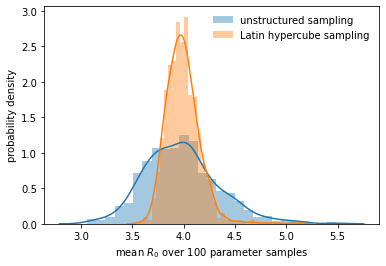

In [3]:
n_runs = 1000
n_samples = 100


def get_mean_output(sampler, model, parameters, n_samples, n_runs):
    '''For each run in `n_runs`,
    find the mean output of `model()` 
    over `n_samples` samples from `parameters` using
    `sampler()`.'''
    means = []
    for _ in range(n_runs):
        parameter_samples = sampler(parameters, n_samples)
        model_outputs = model(**parameter_samples)
        means.append(numpy.mean(model_outputs))
    return means


means = get_mean_output(sensitivity_analysis.samples_unstructured,
                        model, parameters,
                        n_samples, n_runs)

means_LHS = get_mean_output(sensitivity_analysis.samples_Latin_hypercube,
                            model, parameters,
                            n_samples, n_runs)

seaborn.distplot(means, label='unstructured sampling')
seaborn.distplot(means_LHS, label='Latin hypercube sampling')
pyplot.xlabel(f'mean $R_0$ over {n_samples} parameter samples')
pyplot.ylabel('probability density')
_ = pyplot.legend()

Both sampling schemes give the same mean $R_0$ of around 4, but the variation in the estimates is much smaller with Latin hypercube sampling.

# PRCC

In [4]:
n_samples = 100
X = sensitivity_analysis.samples_Latin_hypercube(parameters, n_samples)
y = model(**X)

## Correlation coefficient

In [5]:
sensitivity_analysis.stats.CC(X, y)

β    0.539824
γ   -0.597075
μ   -0.003293
dtype: float64

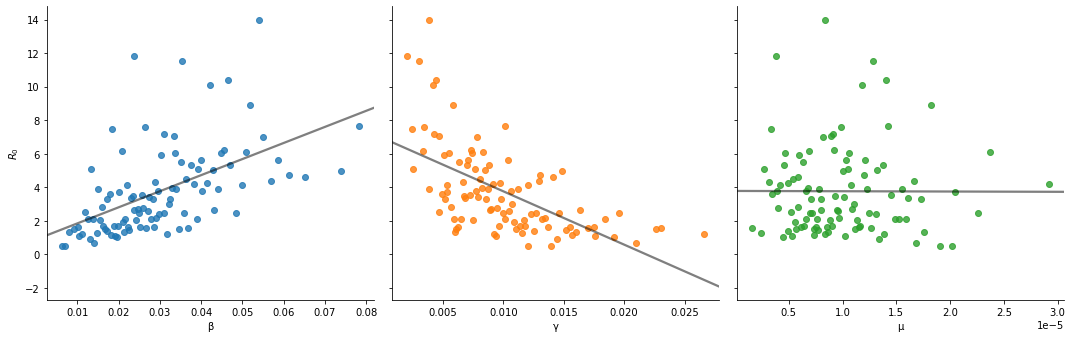

In [6]:
fg = sensitivity_analysis.scatterplots_samples(X, y)

## Partial correlation coefficient

In [7]:
sensitivity_analysis.stats.PCC(X, y)

β    0.750521
γ   -0.776265
μ   -0.034893
dtype: float64

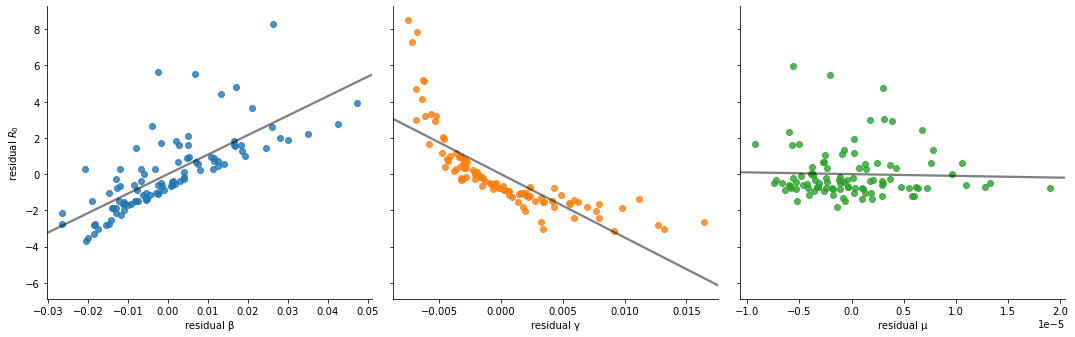

In [8]:
fg = sensitivity_analysis.residualplots_samples(X, y)

## Rank correlation coefficient

In [9]:
sensitivity_analysis.stats.RCC(X, y)

β    0.645197
γ   -0.648569
μ   -0.008185
dtype: float64

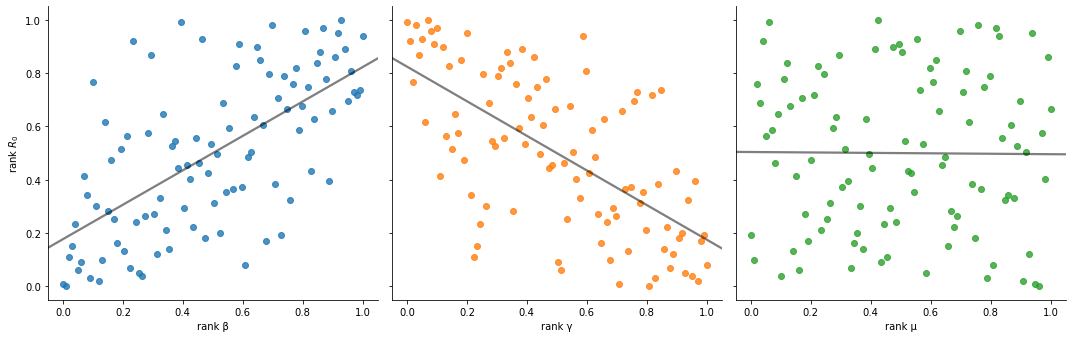

In [10]:
X_rank = sensitivity_analysis.stats.rank(X)
X_rank.set_axis('rank ' + X.columns, axis='columns', inplace=True)
y_rank = sensitivity_analysis.stats.rank(y)
y_rank.rename('rank ' + y.name, inplace=True)
fg = sensitivity_analysis.scatterplots_samples(X_rank, y_rank)

## Partial rank correlation coefficient

In [11]:
sensitivity_analysis.stats.PRCC(X, y)

β    0.939712
γ   -0.940047
μ   -0.010614
dtype: float64

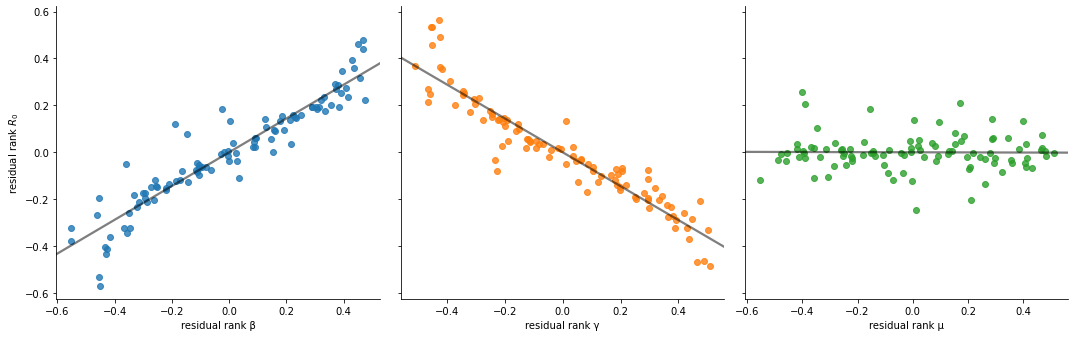

In [12]:
fg = sensitivity_analysis.residualplots_samples(X_rank, y_rank)

# Sobol' indexes

The first-order index is
$$S_i = \frac{\mathrm{V}_{X_i}\big(\mathrm{E}_{X_{\sim i}}(Y|X_i)\big)}{\mathrm{V}(Y)},$$
and the total-order index is
$$S_{\mathrm{T}i} = \frac{\mathrm{E}_{X_{\sim i}}\big(\mathrm{V}_{X_i}(Y|X_{\sim i})\big)}{\mathrm{V}(Y)}.$$


In [13]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', 'Total-order index ($S_T$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


n_samples = 1000
(S, S_PE, S_T, S_T_PE) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples)
display_Sobol_indexes(S, S_PE, S_T, S_T_PE)